Notes:
- doesn't work even without transit
- try changing priors

Found bug! Independent variable = time for all submodels!!!

In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


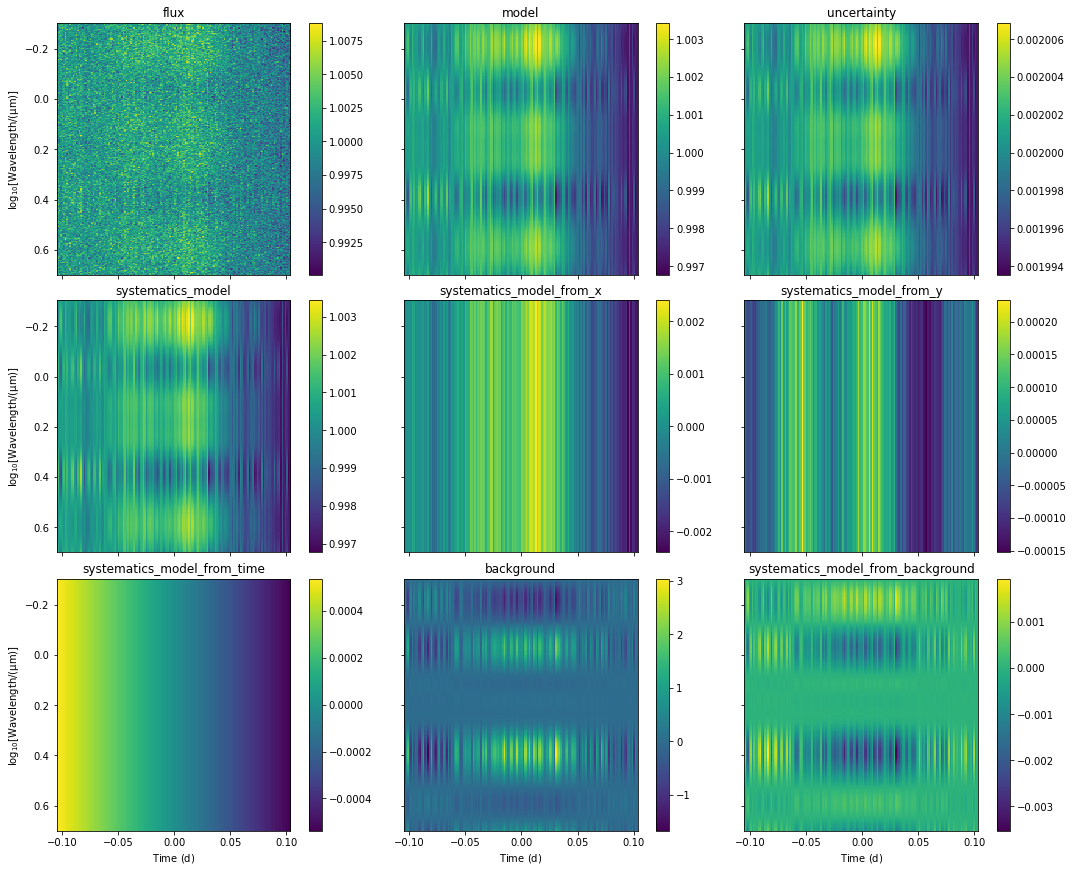

In [2]:
s = SimulatedRainbow().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [3]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.001),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.001),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.001),
)

In [4]:
b_x.parameters

{'sx_p_0': <🧮 Fixed | 0.0 🧮>,
 'sx_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.001, name='p_1') 🧮>}

In [5]:
b.parameters

{'stime_p_0': <🧮 Fixed | 1 🧮>,
 'stime_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [6]:
cm = b + b_x + b_y + b_bkg

In [7]:
cm

<chromatic combined model 🌈, models: stime(<chromatic polynomial model 🌈>) + sx(<chromatic polynomial model 🌈>) + sy(<chromatic polynomial model 🌈>) + sbkg(<chromatic polynomial model 🌈>)

In [8]:
cm.chromatic_models

{'stime': <chromatic polynomial model 🌈>,
 'sx': <chromatic polynomial model 🌈>,
 'sy': <chromatic polynomial model 🌈>,
 'sbkg': <chromatic polynomial model 🌈>}

In [9]:
cm.how_to_combine

['+', '+', '+']

In [10]:
cm.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.001, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.001, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.001, name='sbkg_p_1') 🧮>



In [11]:
cm.attach_data(s)
cm.setup_lightcurves()
cm.setup_likelihood()

In [12]:
print(cm.chromatic_models)
print()
print(cm.pymc3_model)

{'stime': <chromatic polynomial model 🌈>, 'sx': <chromatic polynomial model 🌈>, 'sy': <chromatic polynomial model 🌈>, 'sbkg': <chromatic polynomial model 🌈>}

        stime_p_1 ~ Normal
           sx_p_1 ~ Normal
           sy_p_1 ~ Normal
         sbkg_p_1 ~ Normal
wavelength_0_data ~ Normal
wavelength_1_data ~ Normal
wavelength_2_data ~ Normal
wavelength_3_data ~ Normal
wavelength_4_data ~ Normal


In [ ]:
## combine the models - old method!
# cm = CombinedModel()
# cm.initialize_empty_model()
# cm.attach_models({'time':b,'x':b_x,'y':b_y,'background':b_bkg}, how_to_combine="+") #'transit':t,
# cm.attach_data(s)
# cm.setup_lightcurves()
# cm.setup_likelihood()
# print(cm.chromatic_models)
# print(cm.pymc3_model)

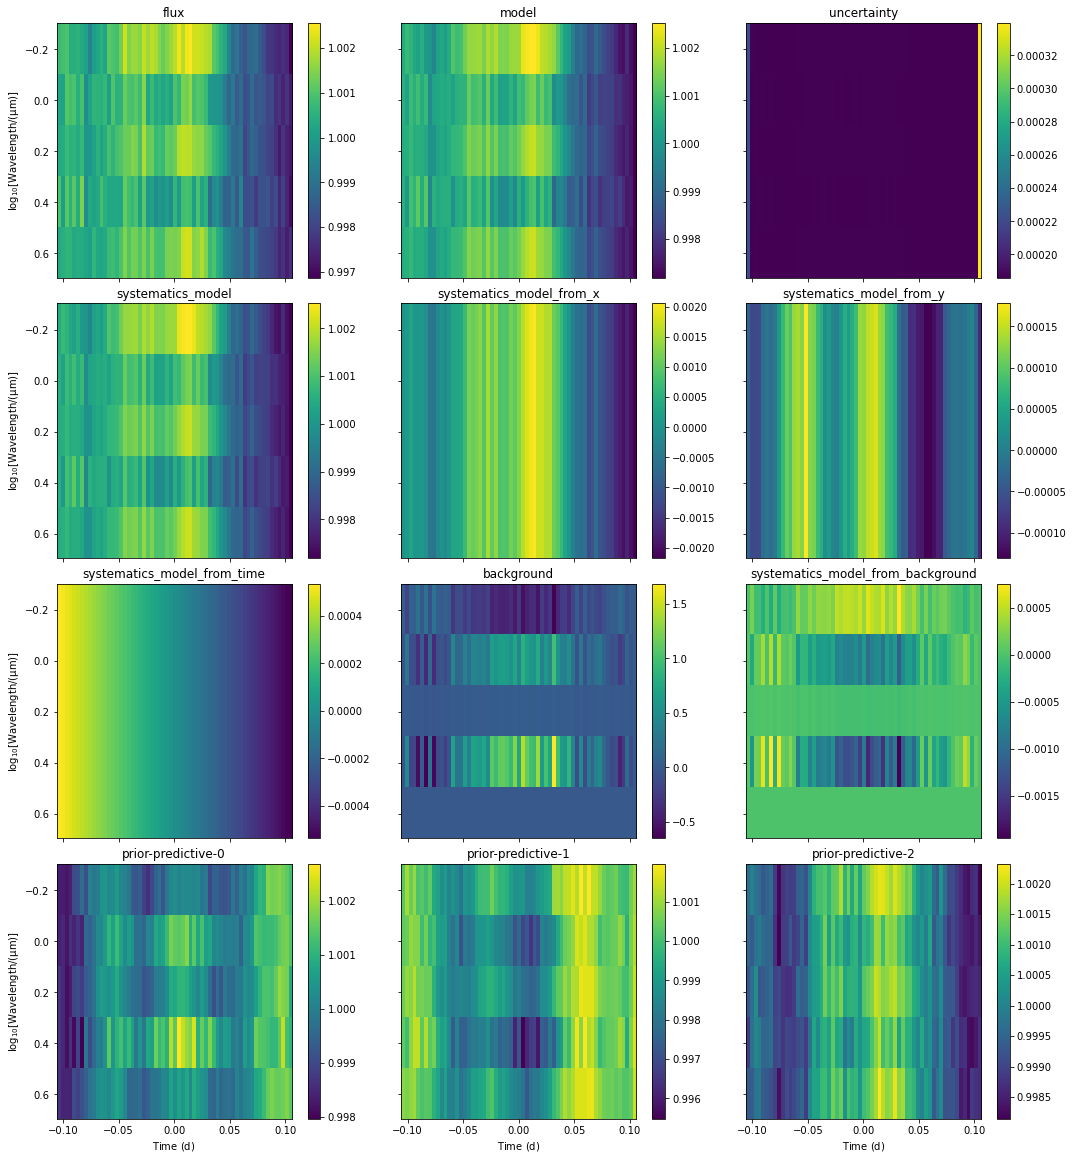

In [13]:
cm.plot_priors()

In [14]:
opt = cm.optimize()
cm.sample(start=opt, cores=12, chains=4)
cm.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -5057.557735238681 -> 2233.124896061201



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


               mean        sd    hdi_3%   hdi_97%     mcse_mean       mcse_sd  \
stime_p_1 -0.005292  0.000198 -0.005657 -0.004913  3.100000e-06  2.200000e-06   
sx_p_1     0.001139  0.000014  0.001113  0.001167  2.000000e-07  2.000000e-07   
sy_p_1     0.000101  0.000020  0.000063  0.000136  3.000000e-07  2.000000e-07   
sbkg_p_1  -0.001177  0.000031 -0.001229 -0.001114  5.000000e-07  4.000000e-07   

              ess_bulk     ess_tail     r_hat  
stime_p_1  4180.976272  3039.044156  1.000533  
sx_p_1     4518.719860  2764.724582  1.001386  
sy_p_1     4019.117053  2885.458064  0.999539  
sbkg_p_1   3708.767937  2528.633578  1.000090  



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

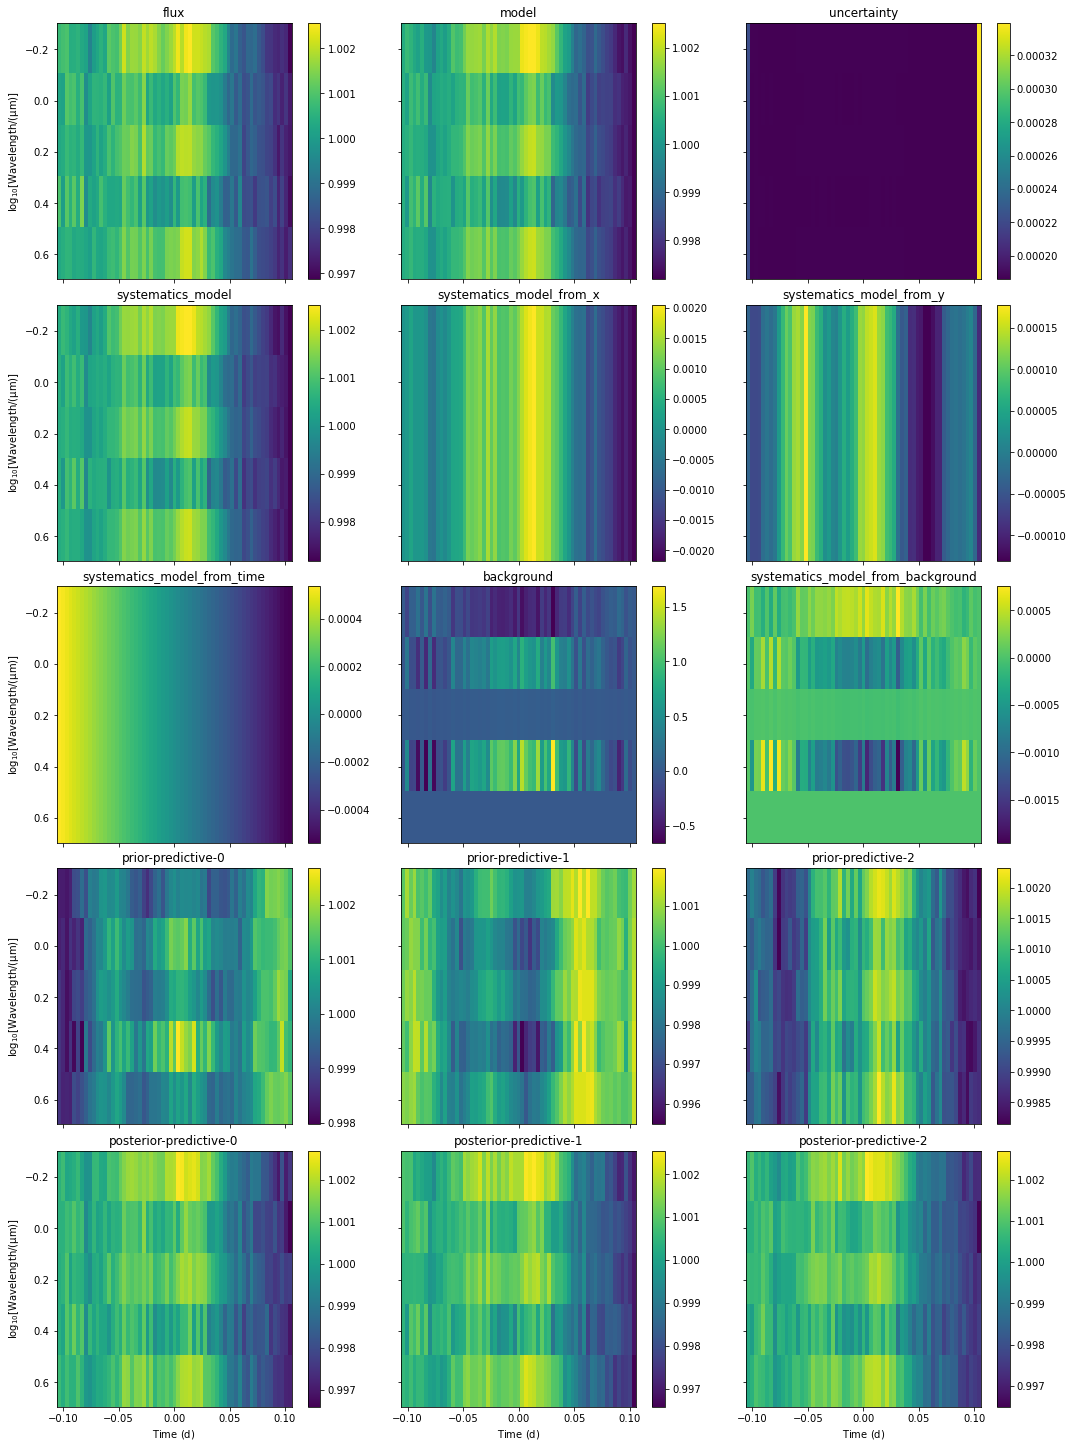

In [15]:
cm.plot_posteriors()

In [16]:
cm.summary['mean']

stime_p_1   -0.005292
sx_p_1       0.001139
sy_p_1       0.000101
sbkg_p_1    -0.001177
Name: mean, dtype: float64

In [17]:
print(s.metadata['systematics_equation'])
print()
for k, v in s.metadata['systematics_components'].items():
    print(f'{k:>20} = {repr(v)}')

f = 1
  + c_x*(x - offset_x)/sigma_x
  + c_y*(y - offset_y)/sigma_y
  + c_time*(time - offset_time)/sigma_time
  + c_background*(background - offset_background)/sigma_background

            linear_x = 'c_x*(x - offset_x)/sigma_x'
                 c_x = 0.001134903273027555
            offset_x = 0
             sigma_x = 1
            linear_y = 'c_y*(y - offset_y)/sigma_y'
                 c_y = 0.0001259989627843135
            offset_y = 0
             sigma_y = 1
         linear_time = 'c_time*(time - offset_time)/sigma_time'
              c_time = -0.00031267494308683636
         offset_time = <Quantity -0.00069444 d>
          sigma_time = <Quantity 0.06013932 d>
   linear_background = 'c_background*(background - offset_background)/sigma_background'
        c_background = -0.00115953418615577
   offset_background = 0
    sigma_background = 1


In [22]:
meta = s.metadata['systematics_components']
systematics_model = 1 + \
        (meta['c_x'] * s.x) + \
        (meta['c_y'] * s.y) + \
        (meta['c_time'] * ((s.time.to_value("day")-meta['c_time'])/meta['sigma_time'].to_value("day"))) + \
        (meta['c_background'] * s.background) 
cm.data.fluxlike['test_residuals-0'] = cm.data.fluxlike['posterior-predictive-0'] - systematics_model

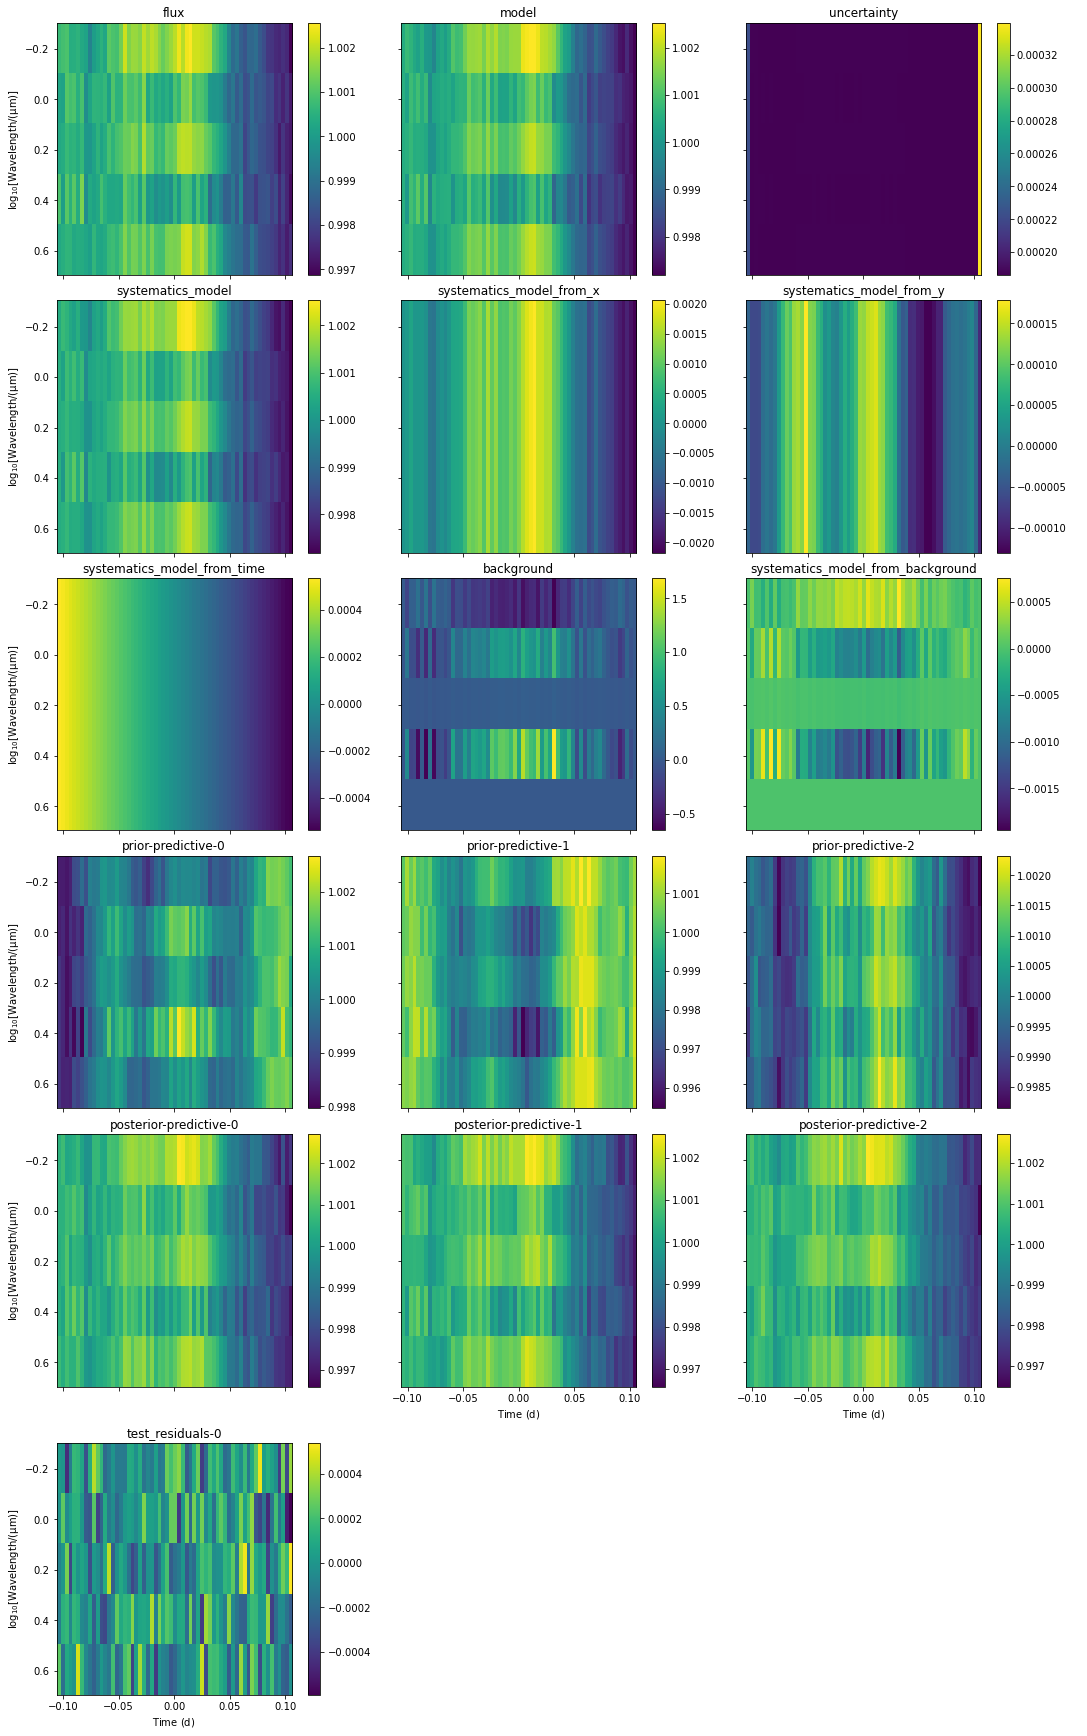

In [23]:
cm.data.imshow_quantities()